# 4 - CNN and Autoencoders

## 4.1 - Data visualization and preprocessing

In [1]:
import torch

# Check if a GPU is available and print the GPU type
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available.")


No GPU available.


In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


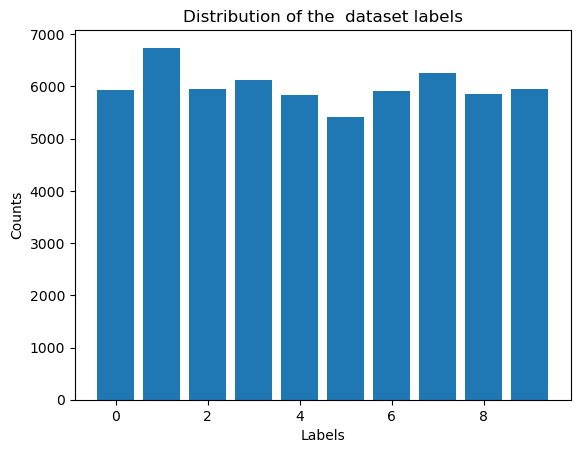

In [3]:
def label_distribution(dataset):
  labels = dataset.targets.numpy()
  unique, counts = np.unique(labels, return_counts=True)
  plt.bar(unique, counts)
  plt.title('Distribution of the  dataset labels')
  plt.xlabel('Labels')
  plt.ylabel('Counts')
  plt.show()

# distribution of the training set labels
label_distribution(trainset)

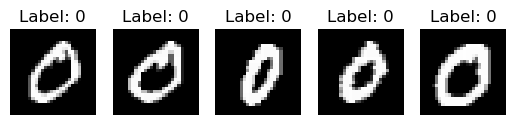

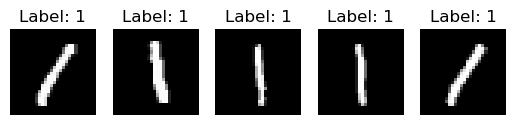

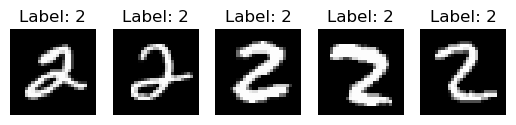

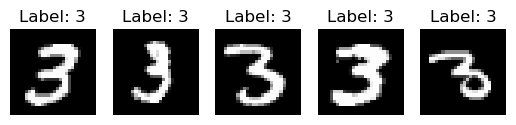

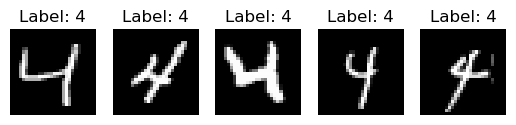

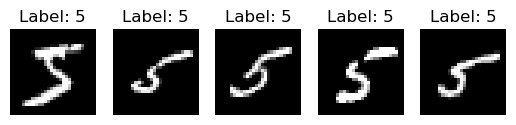

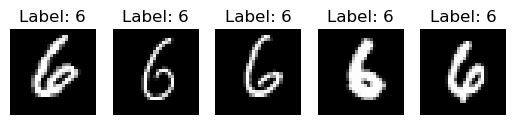

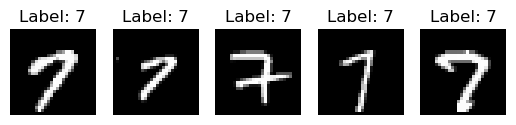

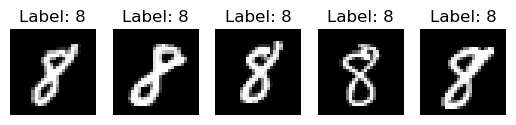

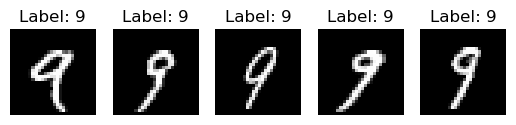

In [4]:
# visualize 5 samples from each unique label
def visualize_samples(dataset, num_samples_per_class=5):
  images = dataset.data.numpy()
  labels = dataset.targets.numpy()
  for i in range(10):
    for j in range(num_samples_per_class):
        plt.subplot(2, 5, j+1)
        plt.imshow(images[labels == i][j], cmap='gray')
        plt.title('Label: ' + str(i))
        plt.axis('off')
    plt.show()

visualize_samples(trainset,5)


#### no of 1's are maximum and no of 5's are minimum

In [5]:
# partition the training set into training and validation sets
from sklearn.model_selection import train_test_split

train_images = trainset.data.numpy()
train_labels = trainset.targets.numpy()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



## 4.2 - Model Building

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(64 * 5 * 5, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.dropout(x)
        x = self.fc(x)
        return x



cpu


In [ ]:

import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image

# Function to visualize feature maps for a given model and input image
def visualize_feature_maps(model, layer_name, img_path):
    # Load and transform the input image
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)  # Add batch dimension

    # Get the activations of the specified layer for the input image
    activation = None
    for name, layer in model.named_children():
        if name == layer_name:
            activation = layer.register_forward_hook(get_activation)

    if activation is None:
        print("Layer not found in the model.")
        return

    model.eval()
    with torch.no_grad():
        model(img_tensor)

    activation.remove()

def get_activation(module, input, output):
    global activation
    activation = output

# # Load a pre-trained model
# model = CNN()  
# layer_to_visualize = 1  # Layer index or name, you need to adjust this to your model

# # Set the model to evaluation mode
# model.eval()

# # Visualize feature maps of a specific layer
# visualize_feature_maps(model, layer_to_visualize, train_images[0])

## 4.3 - Hyperparameter Tuning and Evaluation

In [10]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="Ass3-CNN")
model = CNN().to(device)


In [5]:
from sklearn.model_selection import train_test_split
# Define data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training, validation, and test sets
train_data, validation_data = train_test_split(mnist_train, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
# validation_loader = DataLoader(validation_data, batch_size=config.batch_size, shuffle=False)
# test_loader = DataLoader(mnist_test, batch_size=config.batch_size, shuffle=False)

In [5]:
# # Initialize W&B project and define sweep configuration
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'mnist_cnn_sweep2',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'lr': {'values': [0.001, 0.01, 0.0001]},  # Learning rate values to experiment with
        'batch_size': {'values': [32, 64, 128]},  # Batch size values to experiment with
        'num_epochs': {'values': [5, 10, 15]},  # Number of epochs to experiment with
        'dropout_rate': {'values': [0.0, 0.25, 0.5]},  # Dropout rates to experiment with
        'optimizer': {'values': ['adam']},
    }
}
# sweep_config = {
#     'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
#     'name': 'mnist_cnn_sweep_try',
#     'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
#     'parameters': {
#         'lr': {'values': [0.01]},  # Learning rate values to experiment with
#         'batch_size': {'values': [32]},  # Batch size values to experiment with
#         'num_epochs': {'values': [5]},  # Number of epochs to experiment with
#         'dropout_rate': {'values': [0.0]},  # Dropout rates to experiment with
#         'optimizer': {'values': ['adam']},
#     }
# }
# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="Ass3-CNN")

Create sweep with ID: mlx58o6j
Sweep URL: https://wandb.ai/guptayatharth1/Ass3-CNN/sweeps/mlx58o6j


## 4.4 - Model Evaluation and Analysis

In [6]:
def train():
    # Set up a new run for each experiment
    with wandb.init() as run:
        # Initialize hyperparameters for the experiment
        config = run.config

        # Create an instance of the CNN model and move it to the GPU
        model = CNN().to(device)

        # Define the loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.lr)

        # Create data loaders with the specified batch size
        train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(validation_data, batch_size=config.batch_size, shuffle=False)

        # Training the model
        for epoch in range(config.num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)  # Move data to the GPU
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train

            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)  # Move data to the GPU
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct_val / total_val

            wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
                      "val_loss": val_loss, "val_accuracy": val_accuracy}, step=epoch)

        # Model Evaluation
        model.eval()
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to the GPU
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
                  "val_loss": val_loss, "val_accuracy": val_accuracy}, step=epoch)

        # Calculate and log classification report and confusion matrix to W&B
        class_names = [str(i) for i in range(10)]
        classification_rep = classification_report(all_targets, all_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], target_names=class_names, output_dict=True, zero_division=1)  # Handle undefined metrics
        confusion_mat = confusion_matrix(all_targets, all_predictions)

        # Log results and hyperparameters
        wandb.log({"classification_report": classification_rep, "confusion_matrix": wandb.plot.confusion_matrix(probs=None,y_true=all_targets, preds=all_predictions,class_names=class_names)})

        best_accuracy = 0.0
        # Inside your validation loop (or at the end of each run)
        if val_accuracy > best_accuracy:
            # Update the best accuracy
            best_accuracy = val_accuracy

            # Save the state dictionary of the model
            torch.save(model.state_dict(), "best_model.pth")
            torch.save(config.lr,"lr.pth")
            torch.save(config.batch_size,"batch_size.pth")
            torch.save(config.num_epochs,"num_epochs.pth")

            # # Log the best model as an artifact
            # artifact = wandb.Artifact("best_model", type="model")
            # artifact.add_file("best_model.pth")  # Add the saved model file
            # run.log_artifact(artifact)  # Use the artifact in the current run

# def train():
#     # Set up a new run for each experiment
#     with wandb.init() as run:
#         # Initialize hyperparameters for the experiment
#         config = run.config

#         # Create an instance of the CNN model and move it to the GPU
#         model = CNN().to(device)

#         # Define the loss and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=config.lr)

#         # Create data loaders with the specified batch size
#         # Split the data into training, validation, and test sets
#         train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
#         validation_loader = DataLoader(validation_data, batch_size=config.batch_size, shuffle=False)
#         test_loader = DataLoader(mnist_test, batch_size=config.batch_size, shuffle=False)

#         # Training the model
#         for epoch in range(config.num_epochs):
#             model.train()
#             running_loss = 0.0
#             correct_train = 0
#             total_train = 0

#             for images, labels in train_loader:
#                 optimizer.zero_grad()
#                 images, labels = images.to(device), labels.to(device)  # Move data to the GPU
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss.item()

#                 _, predicted = torch.max(outputs, 1)
#                 total_train += labels.size(0)
#                 correct_train += (predicted == labels).sum().item()

#             train_loss = running_loss / len(train_loader)
#             train_accuracy = 100 * correct_train / total_train

#             # Validation
#             model.eval()
#             correct_val = 0
#             total_val = 0
#             val_loss = 0.0

#             with torch.no_grad():
#                 for images, labels in validation_loader:
#                     images, labels = images.to(device), labels.to(device)  # Move data to the GPU
#                     outputs = model(images)
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item()
#                     _, predicted = torch.max(outputs, 1)
#                     total_val += labels.size(0)
#                     correct_val += (predicted == labels).sum().item()

#             val_loss = val_loss / len(validation_loader)
#             val_accuracy = 100 * correct_val / total_val

#             wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
#                       "val_loss": val_loss, "val_accuracy": val_accuracy}, step=epoch)

#         # Model Evaluation
#         model.eval()
#         correct_test = 0
#         total_test = 0
#         test_loss = 0.0
#         test_targets = []
#         test_predictions = []

#         with torch.no_grad():
#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)  # Move data to the GPU
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
        #         test_loss += loss.item()
        #         _, predicted = torch.max(outputs, 1)
        #         total_test += labels.size(0)
        #         correct_test += (predicted == labels).sum().item()

        #         test_targets.extend(labels.cpu().numpy())
        #         test_predictions.extend(predicted.cpu().numpy())

        # test_loss = test_loss / len(test_loader)
        # test_accuracy = 100 * correct_test / total_test

#         wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})

#         # Calculate and log classification report and confusion matrix to W&B
#         class_names = [str(i) for i in range(10)]
#         classification_rep = classification_report(test_targets, test_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], target_names=class_names, output_dict=True, zero_division=1)  # Handle undefined metrics
        # confusion_mat = confusion_matrix(test_targets, test_predictions)
        # print(confusion_mat)

#         # Log results and hyperparameters
#         wandb.log({"classification_report": classification_rep, "confusion_matrix": wandb.plot.confusion_matrix(probs=None,y_true=test_targets, preds=test_predictions,class_names=class_names)})



#### we see as we increase dropout rate the train accuracy increases then decreases

In [7]:
# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    Exception in thread self.run()NetStatThr
    :
  File "/usr/lib/python3.10/threading.py", line 953, in run
self.run()Traceback (most recent call last):

      File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
  File "/usr/lib/python3.10/threading.py", line 953, in run
self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 268, in check_network_status
    self._

train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
train_accuracy,98.88333
train_loss,0.03412
val_accuracy,98.91667
val_loss,0.03854


wandb: Agent Starting Run: z7o4u3hw with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▅▆████
val_loss,█▄▂▂▃▃▁▂▂▂
train_accuracy,99.36667
train_loss,0.01868
val_accuracy,99.05833
val_loss,0.03898


wandb: Agent Starting Run: we5y1lpd with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▆▇▇▇█████████
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▆▇▅█▇▇▇▇▇█
val_loss,█▅▂▁▁▂▂▄▁▁▂▂▃▃▂
train_accuracy,99.55417
train_loss,0.01359
val_accuracy,99.10833
val_loss,0.03924


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3bmlz7h7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆█▇█
val_loss,█▃▁▂▁
train_accuracy,95.54792
train_loss,0.14726
val_accuracy,97.375
val_loss,0.08874


wandb: Agent Starting Run: tyil7c2f with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█▇██
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅█▅▆█▅█▇
val_loss,█▅▃▁▄▃▂▅▁▁
train_accuracy,96.52083
train_loss,0.11894
val_accuracy,97.49167
val_loss,0.08017


wandb: Agent Starting Run: ul8i7jk1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▅▇▇███████████
train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆█▇▇▆▅▇▆█▇▇▇█
val_loss,█▆▃▂▂▁▃▅▂▃▁▃▂▃▃
train_accuracy,96.1625
train_loss,0.1273
val_accuracy,97.78333
val_loss,0.08333


wandb: Agent Starting Run: ch9esg5h with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
train_accuracy,97.74167
train_loss,0.07404
val_accuracy,98.075
val_loss,0.06461


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5fos1tbw with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,98.55625
train_loss,0.04949
val_accuracy,98.60833
val_loss,0.0476


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fb3ag8yi with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇██████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,98.8875
train_loss,0.03619
val_accuracy,98.75
val_loss,0.04199


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wolhrpnx with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇█▄
val_loss,█▃▁▁▅
train_accuracy,99.01875
train_loss,0.03189
val_accuracy,98.56667
val_loss,0.04959


wandb: Agent Starting Run: uq6pfwt1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▆██▇████
val_loss,█▅▃▂▂▁▁▂▁▂
train_accuracy,99.32292
train_loss,0.01944
val_accuracy,98.99167
val_loss,0.03913


wandb: Agent Starting Run: uujptlsn with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▆▇▇▇▇████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇█▇▇▆▇▇▇▇█
val_loss,█▃▃▂▂▂▁▁▂▂▁▃▂▃▂
train_accuracy,99.45208
train_loss,0.01499
val_accuracy,99.1
val_loss,0.04006


wandb: Agent Starting Run: 25jkjcp0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇▇█
train_loss,█▂▂▂▁
val_accuracy,▁▆▆█▇
val_loss,█▃▃▂▁
train_accuracy,94.925
train_loss,0.16396
val_accuracy,96.98333
val_loss,0.09289


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xs41o53 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▇▇▇▇▇███▇
train_loss,█▂▂▂▁▁▁▁▁▂
val_accuracy,▁▂▁▁█▅█▄▁▇
val_loss,▆▅▄▆▁▂▁▇█▃
train_accuracy,97.18125
train_loss,0.10421
val_accuracy,98.28333
val_loss,0.06981


wandb: Agent Starting Run: i8zeot6c with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██▇▇███████
train_loss,█▃▂▁▁▂▁▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅█▆▅▇█▅▇▅▅▅▆▄
val_loss,█▁▂▁▂▃▂▁▂▁▅▂▄▄▄
train_accuracy,96.66458
train_loss,0.11692
val_accuracy,97.64167
val_loss,0.07896


wandb: Agent Starting Run: kz0s6no3 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
train_accuracy,97.75833
train_loss,0.07406
val_accuracy,98.19167
val_loss,0.0644


wandb: Agent Starting Run: d4ip7wj9 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇█▇▇█
val_loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,98.54167
train_loss,0.04857
val_accuracy,98.625
val_loss,0.04744


wandb: Agent Starting Run: z3fi3nr2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇██████
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,98.85417
train_loss,0.03885
val_accuracy,98.70833
val_loss,0.04395


wandb: Agent Starting Run: tgp5tr94 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆██
val_loss,█▅▃▁▁
train_accuracy,98.93958
train_loss,0.03303
val_accuracy,98.975
val_loss,0.03504


wandb: Agent Starting Run: g38f7qhy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▅▆▇▇▇▇▇█
val_loss,█▇▃▃▂▃▁▂▂▃
train_accuracy,99.31875
train_loss,0.02014
val_accuracy,99.03333
val_loss,0.03848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oxlxyaje with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▆▇▇▇▇▇███████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▇▇██▇▇████
val_loss,█▄▄▃▃▁▁▁▂▂▂▂▂▃▂
train_accuracy,99.5125
train_loss,0.01434
val_accuracy,99.09167
val_loss,0.03934


wandb: Agent Starting Run: 5unuyngg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆▅█▃
val_loss,█▁▄▂▅
train_accuracy,96.48542
train_loss,0.11734
val_accuracy,97.5
val_loss,0.08115


wandb: Agent Starting Run: cfiqxqnm with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▂▁▇▆▇▇▇▇▇█
val_loss,▇█▂▃▂▂▂▃▂▁
train_accuracy,96.00417
train_loss,0.13504
val_accuracy,97.88333
val_loss,0.07412


wandb: Agent Starting Run: j5360wz3 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▅▅▆▆▇▇██████▇█
train_loss,█▄▄▃▃▂▁▁▁▁▁▁▁▂▁
val_accuracy,▁▄▄▃▃▅▅▆▇▆▇▇█▆▇
val_loss,█▆▄▅▅▃▅▅▃▃▂▂▁▃▂
train_accuracy,96.30833
train_loss,0.12172
val_accuracy,97.925
val_loss,0.07385


wandb: Agent Starting Run: v327v4ue with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
train_accuracy,97.75208
train_loss,0.07515
val_accuracy,98.05
val_loss,0.06479


wandb: Agent Starting Run: d2htjptv with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
train_accuracy,98.53333
train_loss,0.04682
val_accuracy,98.575
val_loss,0.04754


wandb: Agent Starting Run: u2jravu2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█▇████
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁
train_accuracy,98.89167
train_loss,0.03605
val_accuracy,98.81667
val_loss,0.04173


wandb: Agent Starting Run: 4r9ywxcg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
train_accuracy,98.95
train_loss,0.03437
val_accuracy,98.89167
val_loss,0.03992


wandb: Agent Starting Run: g4tz129f with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▆▇▇█▇██
val_loss,█▄▄▃▂▁▁▁▁▂
train_accuracy,99.27083
train_loss,0.02221
val_accuracy,98.99167
val_loss,0.04173


wandb: Agent Starting Run: yhyxc1kt with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇▇████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇▇▇██▇██
val_loss,█▄▃▃▃▂▂▂▁▂▁▁▂▂▂
train_accuracy,99.525
train_loss,0.01411
val_accuracy,99.00833
val_loss,0.04054


wandb: Agent Starting Run: ml2wsrx8 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▅██
val_loss,█▅▅▁▁
train_accuracy,95.88542
train_loss,0.13492
val_accuracy,97.64167
val_loss,0.07802


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4kbxi8ws with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▄▁▄▅▅▇▅▆█▃
val_loss,▅▆▆▅▄▂▃▄▁█
train_accuracy,97.68542
train_loss,0.07608
val_accuracy,98.21667
val_loss,0.06636


wandb: Agent Starting Run: aqmy424z with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▅▆▅▇▇▄█▇▇██
val_loss,█▅▃▃▄▃▄▃▃▆▁▃▂▁▁
train_accuracy,96.825
train_loss,0.10316
val_accuracy,98.0
val_loss,0.06472


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxbt5fr9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
train_accuracy,97.21667
train_loss,0.09473
val_accuracy,97.48333
val_loss,0.08386


wandb: Agent Starting Run: 6uqpccaz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,98.30417
train_loss,0.05659
val_accuracy,98.275
val_loss,0.05546


wandb: Agent Starting Run: vj865sy2 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇████████
val_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,98.66042
train_loss,0.04492
val_accuracy,98.55
val_loss,0.04644


wandb: Agent Starting Run: qe16ssc4 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▃███
val_loss,█▅▁▁▁
train_accuracy,98.73333
train_loss,0.03914
val_accuracy,98.71667
val_loss,0.04358


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9wy8ehi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▃▇▆▇▇█▇█
val_loss,█▆▆▂▃▂▁▁▂▁
train_accuracy,99.325
train_loss,0.02071
val_accuracy,99.10833
val_loss,0.03411


wandb: Agent Starting Run: i9xcbddj with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▆▇▇█▇▇██
val_loss,█▆▅▃▃▂▃▂▁▁▂▂▂▁▁
train_accuracy,99.50625
train_loss,0.01541
val_accuracy,99.15833
val_loss,0.03378


wandb: Agent Starting Run: o0pvet58 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▄▇▄█▁
val_loss,▁▃▄▄█
train_accuracy,97.0375
train_loss,0.09411
val_accuracy,97.83333
val_loss,0.07227


wandb: Agent Starting Run: nx960v36 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▇▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▇▇▇██▇█▇
val_loss,█▄▂▁▃▁▁▂▁▂
train_accuracy,97.02708
train_loss,0.09881
val_accuracy,97.93333
val_loss,0.06973


wandb: Agent Starting Run: g76dt2h7 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█▇████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃█▅▅▆▅▄▆▆▃▄▄▅
val_loss,▇▆▅▁▃▄▃▄▄▄▆▇▄█▅
train_accuracy,97.89375
train_loss,0.07143
val_accuracy,98.34167
val_loss,0.0617


wandb: Agent Starting Run: qv616bap with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
train_accuracy,97.24167
train_loss,0.09227
val_accuracy,97.74167
val_loss,0.07897


wandb: Agent Starting Run: 4lmm5l7p with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,98.2125
train_loss,0.05918
val_accuracy,98.31667
val_loss,0.05638


wandb: Agent Starting Run: 6u9ie9wi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇████████
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,98.71667
train_loss,0.04363
val_accuracy,98.5
val_loss,0.04715


wandb: Agent Starting Run: tkuxpo09 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
train_accuracy,98.88958
train_loss,0.03508
val_accuracy,98.80833
val_loss,0.03882


wandb: Agent Starting Run: 8vfqsrjr with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▆▆▇▇▆█▇
val_loss,█▄▅▂▂▂▂▅▁▃
train_accuracy,99.34583
train_loss,0.02047
val_accuracy,98.96667
val_loss,0.04098


wandb: Agent Starting Run: pmn09e8u with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇▇████████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▆▆▇██▇███
val_loss,█▄▃▂▁▁▂▂▂▂▁▁▂▁▁
train_accuracy,99.48333
train_loss,0.01525
val_accuracy,98.95833
val_loss,0.03631


wandb: Agent Starting Run: vp6qs6ox with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▃█
val_loss,█▅▂▇▁
train_accuracy,96.18125
train_loss,0.12416
val_accuracy,98.0
val_loss,0.06867


wandb: Agent Starting Run: 4lskq2w9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▇▆▆▄▁▆█
val_loss,█▅▅▂▁▁▅█▂▃
train_accuracy,97.53958
train_loss,0.07871
val_accuracy,98.4
val_loss,0.06187


wandb: Agent Starting Run: ewjfvsxj with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


wandb: Network error (ConnectionError), entering retry loop.


train_accuracy,▁▇▇▇███████████
train_loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▆▆▅▆▄▇▆▅█▆▇
val_loss,█▅▃▅▄▂▃▄▅▂▂▄▁▁▁
train_accuracy,97.51667
train_loss,0.08077
val_accuracy,98.3
val_loss,0.0571


wandb: Agent Starting Run: 4pku24fb with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
train_accuracy,97.25625
train_loss,0.09276
val_accuracy,97.8
val_loss,0.07734


wandb: Agent Starting Run: wzf1s22g with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
train_accuracy,98.11458
train_loss,0.061
val_accuracy,98.30833
val_loss,0.05588


wandb: Agent Starting Run: co0xi661 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇███████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,98.61875
train_loss,0.04419
val_accuracy,98.61667
val_loss,0.04576


wandb: Agent Starting Run: li6ud5et with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▄██▇
val_loss,█▄▁▁▁
train_accuracy,98.55417
train_loss,0.04572
val_accuracy,98.4
val_loss,0.05323


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v5zer9jl with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▆▇█▇██
val_loss,█▅▃▂▃▂▂▂▁▂
train_accuracy,99.19792
train_loss,0.02307
val_accuracy,98.825
val_loss,0.04102


wandb: Agent Starting Run: cg3kjrhe with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▆▇▇▇▇█▇█▇██
val_loss,█▄▃▂▂▂▂▂▂▁▂▁▂▂▁
train_accuracy,99.43333
train_loss,0.01693
val_accuracy,99.0
val_loss,0.03586


wandb: Agent Starting Run: blmqmteg with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▂▄▅█
val_loss,█▇█▅▁
train_accuracy,97.58542
train_loss,0.07526
val_accuracy,98.35
val_loss,0.05663


wandb: Agent Starting Run: hiy4hg5d with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▄▇█▆▆█▇
val_loss,█▆▄▅▂▂▃▃▁▂
train_accuracy,97.6375
train_loss,0.07645
val_accuracy,98.29167
val_loss,0.05814


wandb: Agent Starting Run: cgih6b3u with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇▇████▇███
train_loss,█▃▂▂▂▂▂▁▁▁▁▂▁▁▁
val_accuracy,▁▄▆▆▅▆▆▄▅▅█▄███
val_loss,█▄▃▂▄▄▂▆▄▃▁▄▂▁▃
train_accuracy,98.08958
train_loss,0.06087
val_accuracy,98.64167
val_loss,0.0531


wandb: Agent Starting Run: wdbnth8v with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
train_accuracy,96.53958
train_loss,0.12341
val_accuracy,97.2
val_loss,0.10566


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktm608mu with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
train_accuracy,97.77917
train_loss,0.07532
val_accuracy,98.04167
val_loss,0.06787


wandb: Agent Starting Run: pv2ibxzi with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇███████
val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,98.22917
train_loss,0.05862
val_accuracy,98.30833
val_loss,0.05673


wandb: Agent Starting Run: qs7q8yg1 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
train_accuracy,98.66667
train_loss,0.04277
val_accuracy,98.70833
val_loss,0.0444


wandb: Agent Starting Run: fimsqg5j with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▄▆▇▇▇▇█
val_loss,█▄▃▄▂▁▂▂▁▁
train_accuracy,99.23958
train_loss,0.02343
val_accuracy,99.04167
val_loss,0.03508


wandb: Agent Starting Run: laqceru0 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▇▇▆▇▇▇█▇█▇▇
val_loss,█▅▄▃▂▁▂▂▁▂▁▁▁▂▁
train_accuracy,99.4625
train_loss,0.01638
val_accuracy,98.93333
val_loss,0.03846


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lnka9za6 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▄▆█
val_loss,█▅▅▂▁
train_accuracy,98.0125
train_loss,0.06254
val_accuracy,98.74167
val_loss,0.04592


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4avl5bhr with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▇▇▇▇█████
train_loss,█▂▂▂▂▁▁▁▁▁
val_accuracy,▂▅▁▅▁▅▄█▆▄
val_loss,▇▄▆▃▇▃▆▁▆█
train_accuracy,98.42292
train_loss,0.05104
val_accuracy,98.43333
val_loss,0.06423


wandb: Agent Starting Run: qovt6wlz with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▆▇█▇▇▆██▆█▇▇
val_loss,█▂▂▃▂▁▂▂▃▁▂▄▂▃▃
train_accuracy,98.55833
train_loss,0.04752
val_accuracy,98.7
val_loss,0.05218


wandb: Agent Starting Run: 4vv3gpa7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
train_accuracy,96.57292
train_loss,0.11702
val_accuracy,97.29167
val_loss,0.09761


wandb: Agent Starting Run: z25te0oo with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
train_accuracy,97.75417
train_loss,0.07683
val_accuracy,98.025
val_loss,0.07006


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ybcge2ct with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.25
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇████████
val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,98.375
train_loss,0.05578
val_accuracy,98.30833
val_loss,0.05451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xjmbe3ia with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▆███
val_loss,█▃▁▁▁
train_accuracy,98.675
train_loss,0.04232
val_accuracy,98.54167
val_loss,0.05111


wandb: Agent Starting Run: ddauxw6g with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▁▂▃▁▁▁▁
train_accuracy,99.26042
train_loss,0.0235
val_accuracy,98.83333
val_loss,0.04093


wandb: Agent Starting Run: mqul9wfr with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▇▇▇█▇██▇▇██
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▂▁▁
train_accuracy,99.44167
train_loss,0.01758
val_accuracy,98.95
val_loss,0.03746


wandb: Agent Starting Run: 97nk6bz7 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▁▁▁
val_accuracy,▁▃▇█▇
val_loss,█▆▂▁▂
train_accuracy,97.89792
train_loss,0.06981
val_accuracy,98.45833
val_loss,0.05086


wandb: Agent Starting Run: ay1ph1h2 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▁▄▆▄█████
val_loss,▇█▄▂▅▂▂▂▁▂
train_accuracy,97.62917
train_loss,0.07472
val_accuracy,98.40833
val_loss,0.05332


wandb: Agent Starting Run: k30utm8e with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.01
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇▇▇████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇▇▅██▃▆▇█▇█▅
val_loss,█▅▄▂▂▃▁▁▆▂▂▃▄▂▄
train_accuracy,98.20208
train_loss,0.05759
val_accuracy,98.41667
val_loss,0.0593


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t12qogyh with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 5
wandb: 	optimizer: adam


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
train_accuracy,96.44583
train_loss,0.11875
val_accuracy,97.33333
val_loss,0.09932


wandb: Agent Starting Run: 2tw5euv9 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 10
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
train_accuracy,97.8
train_loss,0.07417
val_accuracy,97.96667
val_loss,0.06945


wandb: Agent Starting Run: evmhuolp with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	lr: 0.0001
wandb: 	num_epochs: 15
wandb: 	optimizer: adam


train_accuracy,▁▆▇▇▇██████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
train_accuracy,98.31875
train_loss,0.05695
val_accuracy,98.45
val_loss,0.05467


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f454ab4efe0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

### Model Evaluation

In [3]:
checkpoint = torch.load("batch_size.pth")
# checkpoint = torch.load("best_model.pth")
print(torch.load("batch_size.pth"))

128


In [6]:
# use the best model from the sweep to make predictions on the test set
model = CNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))
# print(torch.load("best_model.pth"))
criterion = nn.CrossEntropyLoss()
model.eval()

test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)
test_targets = []
test_predictions = []
correct_test = 0
total_test = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the GPU
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_targets.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test

# Calculate and log classification report and confusion matrix
class_names = [str(i) for i in range(10)]
classification_rep = classification_report(test_targets, test_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], target_names=class_names, output_dict=True, zero_division=1)  # Handle undefined metrics

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
confusion_mat = confusion_matrix(test_targets, test_predictions)
print(confusion_mat)
print(classification_rep)

Test Loss: 0.0000, Test Accuracy: 98.50%
[[ 974    0    1    0    0    0    2    2    1    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   3    4 1010    1    1    0    1    8    4    0]
 [   0    0    3  994    0    3    0    7    3    0]
 [   1    0    0    0  976    0    2    0    1    2]
 [   1    0    0    2    0  883    2    1    3    0]
 [   5    3    0    0    3    4  943    0    0    0]
 [   0    3    9    2    0    0    0 1012    1    1]
 [   5    0    3    1    4    1    0    5  950    5]
 [   4    4    0    2   10    4    0    7    2  976]]
{'0': {'precision': 0.9808660624370594, 'recall': 0.9938775510204082, 'f1-score': 0.9873289406994425, 'support': 980.0}, '1': {'precision': 0.987783595113438, 'recall': 0.9973568281938326, 'f1-score': 0.9925471284524332, 'support': 1135.0}, '2': {'precision': 0.9834469328140214, 'recall': 0.9786821705426356, 'f1-score': 0.9810587663914522, 'support': 1032.0}, '3': {'precision': 0.9920159680638723, 'recall': 0.984158415841584

## 4.5 - Train on Noisy Dataset

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import scipy.io
import numpy as np
from torch.utils.data import random_split

class NoisyMNISTDatasetTrain(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset['train_x'].astype(np.float32) / 255.0  # Load training images
        self.labels = dataset['train_y'].argmax(axis=1).astype(np.int64)  # Convert one-hot labels to integers
        self.length = self.data.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class NoisyMNISTDatasetTest(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset['test_x'].astype(np.float32) / 255.0  # Load training images
        self.labels = dataset['test_y'].argmax(axis=1).astype(np.int64)  # Convert one-hot labels to integers
        self.length = self.data.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
# load the dataset
mat = scipy.io.loadmat('./mnist-with-awgn.mat')

from sklearn.model_selection import train_test_split
# Define hyperparameters
batch_size = torch.load('batch_size.pth')
num_epochs = torch.load('num_epochs.pth')
learning_rate = torch.load('lr.pth')

# Create DataLoader for the noisy dataset
noisy_mnist_dataset = NoisyMNISTDatasetTrain(mat)
train_data, test_data = train_test_split(noisy_mnist_dataset, test_size=0.2, random_state=42)
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation
val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [14]:
# Create a model, optimizer, and loss criterion
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [15]:
# Training loop
def train(noisy_mnist_loader, model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Inside your training loop
        for images, labels in noisy_mnist_loader:
            optimizer.zero_grad()

            # Reshape the input to match the model's expected shape
            images = images.view(images.size(0), 1, 28, 28)  # Assuming the images are 28x28 pixels with 1 channel

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(noisy_mnist_loader)
        train_accuracy = 100 * correct_train / total_train

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')

train(train_loader, model, criterion, optimizer, num_epochs)

Epoch 1/15, Train Loss: 1.5388, Train Acc: 62.20%
Epoch 2/15, Train Loss: 0.5394, Train Acc: 84.43%
Epoch 3/15, Train Loss: 0.3958, Train Acc: 88.06%
Epoch 4/15, Train Loss: 0.3257, Train Acc: 90.13%
Epoch 5/15, Train Loss: 0.2762, Train Acc: 91.85%
Epoch 6/15, Train Loss: 0.2414, Train Acc: 92.78%
Epoch 7/15, Train Loss: 0.2144, Train Acc: 93.58%
Epoch 8/15, Train Loss: 0.1918, Train Acc: 94.33%
Epoch 9/15, Train Loss: 0.1777, Train Acc: 94.73%
Epoch 10/15, Train Loss: 0.1628, Train Acc: 95.10%
Epoch 11/15, Train Loss: 0.1520, Train Acc: 95.51%
Epoch 12/15, Train Loss: 0.1423, Train Acc: 95.69%
Epoch 13/15, Train Loss: 0.1355, Train Acc: 95.82%
Epoch 14/15, Train Loss: 0.1314, Train Acc: 96.13%
Epoch 15/15, Train Loss: 0.1238, Train Acc: 96.29%


In [16]:
# Create a classification report
val_loss = 0.0
correct_val = 0
total_val = 0

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in val_loader:
        # Reshape the input to match the model's expected shape
        images = images.view(images.size(0), 1, 28, 28)  # Assuming the images are 28x28 pixels with 1 channel
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Val Loss: 0.1292, Val Accuracy: 96.20%


In [17]:
# Create a classification report
test_loss = 0.0
correct_test = 0
total_test = 0

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        # Reshape the input to match the model's expected shape
        images = images.view(images.size(0), 1, 28, 28)  # Assuming the images are 28x28 pixels with 1 channel
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

# Print the classification report
class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_targets, all_predictions, target_names=class_names)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(classification_rep)

Test Loss: 0.1183, Test Accuracy: 96.54%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1206
           1       0.98      0.98      0.98      1334
           2       0.96      0.96      0.96      1198
           3       0.96      0.96      0.96      1228
           4       0.97      0.97      0.97      1193
           5       0.96      0.97      0.96      1058
           6       0.98      0.97      0.98      1200
           7       0.97      0.96      0.96      1277
           8       0.95      0.94      0.95      1176
           9       0.95      0.95      0.95      1130

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



## 4.6 - Autoencoder class

In [18]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=4, stride=2, padding=1),  # Adjust padding to maintain the size
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)  # Adjust padding to maintain the size
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training the Autoencoder model

In [19]:

# Define hyperparameters (same as in Part 4.5)
batch_size = torch.load('batch_size.pth')
num_epochs = torch.load('num_epochs.pth')
learning_rate = torch.load('lr.pth')

# Create DataLoader for the noisy dataset (same as in Part 4.5)
noisy_mnist_dataset_train = NoisyMNISTDatasetTrain(mat)
noisy_mnist_loader_train = DataLoader(noisy_mnist_dataset_train, batch_size=batch_size, shuffle=True)

In [20]:
# Train the Autoencoder
autoencoder = Autoencoder()
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
autoencoder_criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction

def train_autoencoder(autoencoder_loader, autoencoder, criterion, optimizer, num_epochs):
    autoencoder.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, _ in autoencoder_loader:
            optimizer.zero_grad()
            # Reshape the input to [batch_size, 1, 28, 28] assuming MNIST images
            images = images.view(images.size(0), 1, 28, 28)
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        train_loss = running_loss / len(autoencoder_loader)
        print(f'Autoencoder Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}')

# Training the Autoencoder
train_autoencoder(noisy_mnist_loader_train, autoencoder, autoencoder_criterion, autoencoder_optimizer, num_epochs)


Autoencoder Epoch 1/15, Loss: 0.1019
Autoencoder Epoch 2/15, Loss: 0.0635
Autoencoder Epoch 3/15, Loss: 0.0543
Autoencoder Epoch 4/15, Loss: 0.0504
Autoencoder Epoch 5/15, Loss: 0.0479
Autoencoder Epoch 6/15, Loss: 0.0462
Autoencoder Epoch 7/15, Loss: 0.0449
Autoencoder Epoch 8/15, Loss: 0.0438
Autoencoder Epoch 9/15, Loss: 0.0430
Autoencoder Epoch 10/15, Loss: 0.0423
Autoencoder Epoch 11/15, Loss: 0.0417
Autoencoder Epoch 12/15, Loss: 0.0412
Autoencoder Epoch 13/15, Loss: 0.0407
Autoencoder Epoch 14/15, Loss: 0.0403
Autoencoder Epoch 15/15, Loss: 0.0399


## Denoise the dataset using the trained Autoencoder and using the de-noised dataset

In [21]:

# Denoise the dataset using the trained Autoencoder
denoised_mnist_dataset = []
for noisy_data, labels in noisy_mnist_dataset_train:
    noisy_data = torch.from_numpy(noisy_data)  # Convert NumPy array to PyTorch tensor
    noisy_data = noisy_data.view(1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
    denoised_data = autoencoder(noisy_data)
    denoised_data = denoised_data.view(28, 28)  # Reshape back to 2D [28, 28]
    denoised_mnist_dataset.append((denoised_data, labels))

# Create DataLoader for the denoised dataset
denoised_mnist_loader = DataLoader(denoised_mnist_dataset, batch_size=batch_size, shuffle=True)

# Train your best model on the denoised dataset
# Define a model (same as in Part 4.5)
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop (training your best model on the denoised dataset)
def train_denoised(denoised_mnist_loader, model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in denoised_mnist_loader:
            optimizer.zero_grad()
            images = images.view(images.size(0), 1, 28, 28)  # Reshape input
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)  # Add retain_graph=True here
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(denoised_mnist_loader)
        train_accuracy = (correct_train / total_train) * 100
        print(f'Denoised Dataset - Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
# Training the model on the denoised dataset
train_denoised(denoised_mnist_loader, model, criterion, optimizer, num_epochs)

Denoised Dataset - Epoch 1/15, Train Loss: 1.1541, Train Acc: 71.23%
Denoised Dataset - Epoch 2/15, Train Loss: 0.3996, Train Acc: 87.80%
Denoised Dataset - Epoch 3/15, Train Loss: 0.2978, Train Acc: 90.88%
Denoised Dataset - Epoch 4/15, Train Loss: 0.2462, Train Acc: 92.42%
Denoised Dataset - Epoch 5/15, Train Loss: 0.2133, Train Acc: 93.47%
Denoised Dataset - Epoch 6/15, Train Loss: 0.1932, Train Acc: 94.06%
Denoised Dataset - Epoch 7/15, Train Loss: 0.1772, Train Acc: 94.55%
Denoised Dataset - Epoch 8/15, Train Loss: 0.1664, Train Acc: 94.86%
Denoised Dataset - Epoch 9/15, Train Loss: 0.1576, Train Acc: 95.16%
Denoised Dataset - Epoch 10/15, Train Loss: 0.1493, Train Acc: 95.33%
Denoised Dataset - Epoch 11/15, Train Loss: 0.1437, Train Acc: 95.56%
Denoised Dataset - Epoch 12/15, Train Loss: 0.1376, Train Acc: 95.67%
Denoised Dataset - Epoch 13/15, Train Loss: 0.1334, Train Acc: 95.85%
Denoised Dataset - Epoch 14/15, Train Loss: 0.1295, Train Acc: 95.99%
Denoised Dataset - Epoch 15/1

## Evaluating model on test data

In [22]:

# Evaluate the model on the test data (same as in Part 4.5)
noisy_mnist_dataset_test = NoisyMNISTDatasetTest(mat)
noisy_mnist_loader_test = DataLoader(noisy_mnist_dataset_test, batch_size=batch_size, shuffle=True)
# noisy_mnist_loader_test = DataLoader(noisy_mnist_dataset_test, batch_size=batch_size, shuffle=False)

test_loss = 0.0
correct_test = 0
total_test = 0

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in noisy_mnist_loader_test:
        images = images.view(images.size(0), 1, 28, 28)  # Reshape input
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_loss = test_loss / len(noisy_mnist_loader_test)
test_accuracy = 100 * correct_test / total_test

# Print the classification report for the noisy test dataset
class_names = [str(i) for i in range(10)]
classification_rep_noisy = classification_report(all_targets, all_predictions, target_names=class_names)

print("Results on the noisy test dataset:")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(classification_rep_noisy)

# Evaluate the model on the test data using the denoised model
test_loss = 0.0
correct_test = 0
total_test = 0

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in denoised_mnist_loader:
        images = images.view(images.size(0), 1, 28, 28)  # Reshape input
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_loss = test_loss / len(denoised_mnist_loader)
test_accuracy = 100 * correct_test / total_test

# Print the classification report for the denoised test dataset
classification_rep_denoised = classification_report(all_targets, all_predictions, target_names=class_names)

print("Results on the denoised test dataset (Part 4.6):")
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(classification_rep_denoised)

Results on the noisy test dataset:
Test Loss: 0.0934, Test Accuracy: 97.16%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Results on the denoised test dataset (Part 4.6):
Test Loss: 0.1064, Test Accuracy: 96.70%
              precision    recall  f1-score   support

           0       0